In [1]:
from mne.datasets import multimodal
import mne
mne.set_log_level(verbose='CRITICAL')
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg
from deepmeg.training.trainers import Trainer
from deepmeg.data.datasets import read_epochs_dataset, EpochsDataset
from deepmeg.preprocessing.transforms import zscore
from deepmeg.models import BaseModel
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from collections import defaultdict
from deepmeg.data.utils import make_train_and_val_loaders
from torch.utils.data import DataLoader, Dataset
import torchmetrics
from deepmeg.training.callbacks import PrintingCallback
import matplotlib.pyplot as plt
import numpy as np
from deepmeg.utils.convtools import compute_output_shape, conviter
import scipy as sp
from deepmeg.preprocessing.transforms import one_hot_encoder, one_hot_decoder


def plot_metrics(metrics: dict[str, np.ndarray]):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()


In [2]:
get_sig = lambda t, a, b, f, phi=0: np.exp(
    -(t - a)**2 / (2 * b**2)
) * np.sin(2*np.pi*f*t + phi)

def gen_1d_source(n_epochs, n_times=1000, sfreq=200, lag=200, dlag=40, sigma=40, freqs=[10]):
    t = np.linspace(0, n_times, sfreq)
    freqs = [freqs] if isinstance(freqs, (int, float)) else freqs
    t2 = np.linspace(0, n_times//2, sfreq//2)
    waves = [get_sig(t2, lag, sigma, freq) for freq in freqs]
    X, Y = list(), list()

    for _ in range(n_epochs):
        dlag_ = np.random.randint(0, dlag)
        noise = -1 + 2*np.random.random((sfreq))
        sig = np.zeros(sfreq)

        for wave in waves:
            sig[dlag_: dlag_ + len(wave)] += wave

        X.append(sig + noise)
        Y.append(sig)

    return np.array(X), np.array(Y)

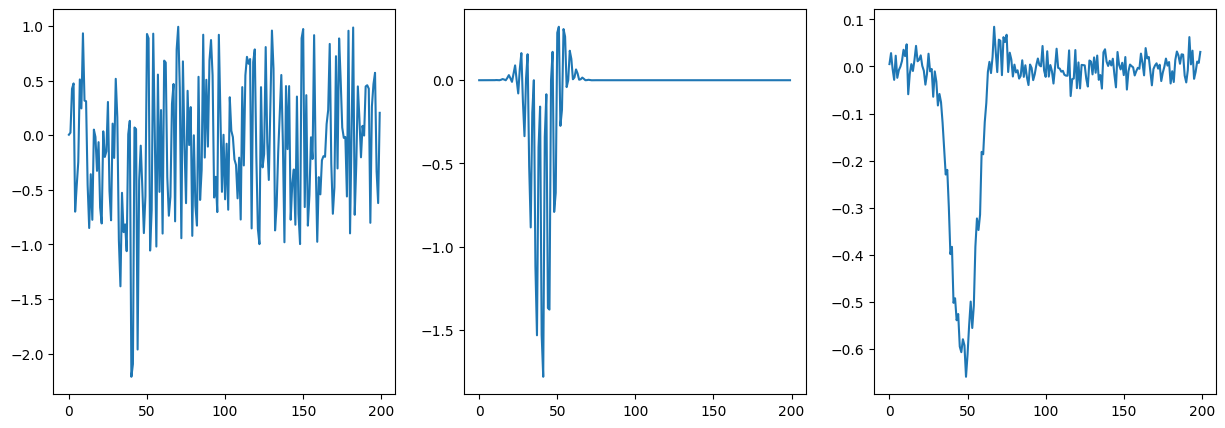

In [5]:
X, Y = gen_1d_source(500, dlag=20, freqs=[5, 40])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.plot(X[0])
ax2.plot(Y[0])
ax3.plot(X.mean(0))

In [6]:
dataset = EpochsDataset((X, Y), transform=zscore, savepath='../datasets/sim_&_noise_1ch')
dataset.save('../data/sim_&_noise_1ch.pt')

In [4]:
dataset = EpochsDataset.load('../data/sim_&_noise_1ch.pt')

In [7]:
train, test = torch.utils.data.random_split(dataset, [.7, .3])

In [8]:
x, y = next(iter(DataLoader(train, len(train))))

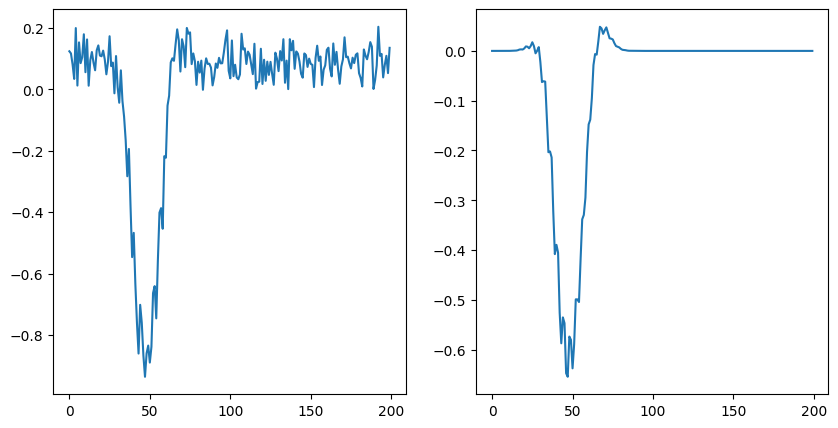

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(x.mean(0))
ax2.plot(y.mean(0))

In [10]:
class EncoderRNN(nn.Module):
    def __init__(self, n_channels, hidden_size):
        super(EncoderRNN, self).__init__()
        self.n_channels = n_channels
        self.hidden_size = hidden_size
        self.gru = nn.GRUCell(self.n_channels, hidden_size)

    def forward(self, input_, hidden=None):
        if hidden is None:
            hidden = self.initHidden(input_)
        input_ = torch.permute(input_, (0, 2, 1))
        hiddens = list()
        for n_timepoint in range(input_.shape[1]):
            timepoint = input_[:, n_timepoint, :]
            hidden = self.gru(timepoint, hiddens[-1] if hiddens else hidden)
            hiddens.append(hidden)

        return torch.stack(hiddens, 1)

    def initHidden(self, input_):
        return torch.zeros(input_.shape[0], self.hidden_size)

X = torch.rand(10, 1, 300)

EncoderRNN(1, 20)(X).shape

torch.Size([10, 300, 20])

In [11]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, n_times, n_channels, enc_hidden_size, dec_hidden_size, attn_hidden_size, dropout=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.n_times = n_times
        self.n_channels = n_channels
        self.enc_hidden_size = enc_hidden_size
        self.dec_hidden_size = dec_hidden_size
        self.attn_hidden_size = attn_hidden_size

        self.attn = nn.Linear(self.enc_hidden_size + self.dec_hidden_size, self.attn_hidden_size)
        self.attn_combine = nn.Linear(self.attn_hidden_size, self.n_channels)
        self.attn_activation = nn.Tanh()
        self.attn_softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(dropout) if dropout else None
        self.gru = nn.GRUCell(self.n_channels, self.dec_hidden_size)
        self.fc = nn.Linear(self.dec_hidden_size, self.n_channels)

    def forward(self, input_, encoder_outputs, hidden=None):
        if hidden is None:
            hidden = self.initHidden(input_)

        input_ = torch.permute(input_, (0, 2, 1))
        if self.dropout:
            input_ = self.dropout(input_)

        hiddens, contexts = list(), list()
        for n_timepoint in range(input_.shape[1]):
            timepoint = input_[:, n_timepoint, :]
            contexts.append(self.one_step_attention(encoder_outputs, hiddens[-1] if hiddens else hidden))
            hidden = self.gru(contexts[-1] + timepoint, hiddens[-1] if hiddens else hidden)
            hiddens.append(hidden)

        return torch.stack(hiddens, 1)
        # out = torch.stack(hiddens, 1) # ~ n_batches x n_times x dec_hidden_size
        # return self.fc(out)

    def initHidden(self, input_):
        return torch.zeros(input_.shape[0], self.dec_hidden_size)

    def one_step_attention(self, a, s_prev):
        # s_prev ~ 1 x n_batches x n_hidden; a ~ n_batches x n_times x n_hidden_dec
        # s_prev = s_prev.repeat(a.shape[1], 1, 1) ~ n_times x n_batches x n_hidden_dec
        # s_prev = torch.permute(s_prev, (1, 0, -1)) ~ n_batches x n_times x n_hidden_dec
        # [s_prev, a] ~ n_batches x n_times x n_hidden_dec + n_hidden_enc
        # intermediate_energies ~ n_batches x n_times x n_hidden_attn
        # energies, alphas ~ n_batches x n_times x n_channels
        # context ~ n_batches x n_channels
        # intermediate_energies = self.attn(torch.concat([a, torch.permute(s_prev.repeat(a.shape[1], 1, 1), (1, 0, -1))], -1))
        intermediate_energies = self.attn_activation(self.attn(torch.concat([a, torch.permute(s_prev.repeat(a.shape[1], 1, 1), (1, 0, -1))], -1)))
        energies = self.attn_combine(intermediate_energies)
        alphas = self.attn_softmax(energies)
        context = torch.permute(torch.permute(a, (0, 2, 1))@alphas, (-1, 0, 1))
        # print('intermediate_energies=', intermediate_energies.shape)
        # print('energies=', energies.shape)
        # print('alphas=', alphas.shape)
        # print('a=', a.shape)
        # print('context=', context.sum(-1).T.shape)

        return context.sum(-1).T


X = torch.rand(100, 1, 300)
enc_out = EncoderRNN(
    n_channels=1,
    hidden_size=20
)(X)
dec_out = AttnDecoderRNN(
    n_times=300,
    n_channels=1,
    dec_hidden_size=1,
    enc_hidden_size=20,
    attn_hidden_size=10
)(X, enc_out)

In [12]:
dec_out.shape

torch.Size([100, 300, 1])

In [14]:
class BahdanauGen(BaseModel):

    def __init__(
        self,
        n_channels: int,
        n_times: int,
        enc_hidden_size: int,
        dec_hidden_size: int,
        attn_hidden_size: int,
    ):
        super().__init__()
        self.n_channels = n_channels
        self.encoder = EncoderRNN(
            n_channels=n_channels,
            hidden_size=enc_hidden_size
        )
        self.decoder = AttnDecoderRNN(
            n_times=n_times,
            n_channels=n_channels,
            enc_hidden_size=enc_hidden_size,
            dec_hidden_size=dec_hidden_size,
            attn_hidden_size=attn_hidden_size
        )

    def forward(self, x: torch.Tensor):
        anno = self.encoder(x)
        return torch.permute(self.decoder(x, anno), (0, 2, 1))

X = torch.rand((1, 64, 600))

BahdanauGen(64, 600, 20, 64, 20)(X).shape

torch.Size([1, 64, 600])

In [16]:
from deepmeg.training.callbacks import Callback
from deepmeg.training.trainers import Trainer
from copy import deepcopy

# class PowerAndNoiseCallback(Callback):
#     def __init__(self):
#         super().__init__()

#     def set_trainer(self, trainer: Trainer):
#         super().set_trainer(trainer)
#         self.generator = self.trainer.generator
#         self.discriminator = self.trainer.discriminator

#     def on_batch_begin(
#         self,
#         X: torch.Tensor,
#         Y: torch.Tensor
#     ):
#         xs_modified = self.generator(X)
#         xs_modified = torch.permute(xs_modified, (0, 2, 1))
#         xs_modified = torch.reshape(xs_modified, (xs_modified.shape[0]*xs_modified.shape[1], xs_modified.shape[-1]))
#         self.x_mod = xs_modified

#     def on_batch_end(
#         self,
#         Y: torch.Tensor,
#         Y_pred: torch.Tensor,
#         metrics: dict
#     ):
#         metrics['noise'] = torch.norm((torch.cov(self.x_mod.T)*self.discriminator.unmixing_layer.weight[:, :, 0].T), p=1)
#         # metrics['noise'] = torch.norm((torch.cov(self.x_mod.T)@self.discriminator.unmixing_layer.weight[:, :, 0].T), p=1)
#         # metrics['noise'] = torch.norm(self.x_mod@self.discriminator.unmixing_layer.weight[:, :, 0].T, 1)
#         metrics['power'] = torch.norm(self.generator.temp_sel.b**2, p=1)


class PowerAndNoiseCallback(Callback):
    def __init__(self):
        super().__init__()

    def set_trainer(self, trainer: Trainer):
        super().set_trainer(trainer)
        self.generator = self.trainer.generator
        self.discriminator = self.trainer.discriminator

    def on_batch_begin(
        self,
        X: torch.Tensor,
        Y: torch.Tensor
    ):
        self.sig = self.generator(X)
        xs_modified = X - self.sig
        xs_modified = torch.permute(xs_modified, (0, 2, 1))
        xs_modified = torch.reshape(xs_modified, (xs_modified.shape[0]*xs_modified.shape[1], xs_modified.shape[-1]))
        self.x_mod = xs_modified

    def on_batch_end(
        self,
        Y: torch.Tensor,
        Y_pred: torch.Tensor,
        metrics: dict
    ):
        metrics['entropy'] = entropy(self.sig**2, -1).mean()
        # metrics['noise'] = torch.norm((torch.cov(self.x_mod.T)*self.discriminator.unmixing_layer.weight[:, :, 0].T), p=1)
        # metrics['power'] = torch.norm(self.sig**2, p=1)
        metrics['power'] = torch.sum(self.sig**2, axis=-1).mean()


class WeightClipper(object):
    def __init__(self, model):
        self.model = model

    def __call__(self, module):
        self.model.temp_conv.weight -= self.model.temp_conv.weight.mean(-1, keepdim=True)

class TempWeightsZeroMean(Callback):
    def __init__(self):
        super().__init__()

    def set_trainer(self, trainer: Trainer):
        super().set_trainer(trainer)
        self.generator = self.trainer.generator
        self.discriminator = self.trainer.discriminator
        self.clipper = WeightClipper(self.generator)

    @torch.no_grad()
    def on_batch_end(
        self,
        Y: torch.Tensor,
        Y_pred: torch.Tensor,
        metrics: dict
    ):
        self.generator.apply(self.clipper)



from deepmeg.training.callbacks import L1Reg
class L1RegGen(L1Reg):

    def set_trainer(self, trainer: 'Trainer'):
        self.trainer = trainer
        self.model = self.trainer.generator

    def on_loss_computed(self, X, Y, Y_pred, loss):
        state_dict = self.model.state_dict()
        disc_loss, gen_loss = loss

        for layer_name, lambda_ in zip(self.layer_names, self.lambdas):
            gen_loss += lambda_*torch.norm(state_dict[layer_name], 1)

        return disc_loss, gen_loss


class L2RegGen(L1RegGen):

    def on_loss_computed(self, X, Y, Y_pred, loss):
        state_dict = self.model.state_dict()
        disc_loss, gen_loss = loss

        for layer_name, lambda_ in zip(self.layer_names, self.lambdas):
            gen_loss += lambda_*torch.norm(state_dict[layer_name], 2)

        return disc_loss, gen_loss


class L1RegDisc(L1Reg):

    def set_trainer(self, trainer: 'Trainer'):
        self.trainer = trainer
        self.model = self.trainer.discriminator

    def on_loss_computed(self, X, Y, Y_pred, loss):
        state_dict = self.model.state_dict()
        disc_loss, gen_loss = loss

        for layer_name, lambda_ in zip(self.layer_names, self.lambdas):
            disc_loss += lambda_*torch.norm(state_dict[layer_name], 1)

        return disc_loss, gen_loss

class L2RegDisc(L1RegDisc):

    def on_loss_computed(self, X, Y, Y_pred, loss):
        state_dict = self.model.state_dict()
        disc_loss, gen_loss = loss

        for layer_name, lambda_ in zip(self.layer_names, self.lambdas):
            disc_loss += lambda_*torch.norm(state_dict[layer_name], 2)

        return disc_loss, gen_loss


class GANEarlyStopping(Callback):
    def __init__(self, patience=5, monitor='gen_loss_train', min_delta=0, restore_best_weights=True):
        super().__init__()
        self.patience = patience
        self.monitor = monitor
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.counter = 0
        self.min_criterion_value = np.inf
        self.best_weights = None

    def set_trainer(self, trainer: Trainer):
        self.trainer = trainer
        self.generator = self.trainer.generator
        self.discriminator = self.trainer.discriminator

    def on_epoch_end(self, epoch_num, metrics):
        criterion_value = metrics[self.monitor]

        if criterion_value < self.min_criterion_value:
            self.min_criterion_value = criterion_value
            self.counter = 0
            self.best_gen_weights = deepcopy(self.generator.state_dict())
            self.best_disc_weights = deepcopy(self.discriminator.state_dict())

        elif criterion_value > (self.min_criterion_value + self.min_delta):
            self.counter += 1

            if self.counter >= self.patience:
                if self.restore_best_weights:
                    self.restore()

                self.trainer.interrupt()

    def restore(self):
        self.generator.load_state_dict(self.best_gen_weights)
        self.discriminator.load_state_dict(self.best_disc_weights)

from deepmeg.utils import check_path

class GANSaver(Callback):
    def __init__(self, savepath: str, save_every_n_iters: int = 50):
        super().__init__()
        self.savepath = savepath
        check_path(self.savepath)
        self.save_every_n_iters = save_every_n_iters

    def set_trainer(self, trainer: Trainer):
        self.trainer = trainer
        self.generator = self.trainer.generator
        self.discriminator = self.trainer.discriminator

    def on_epoch_end(self, epoch_num, metrics):
        if not epoch_num%self.save_every_n_iters:
            folder_name = f'epoch_{epoch_num}'
            savepath = os.path.join(self.savepath, folder_name)
            check_path(savepath)
            self.discriminator.save(os.path.join(savepath, 'discriminator.pt'))
            self.generator.save(os.path.join(savepath, 'generator.pt'))

In [73]:
from deepmeg.experimental.models import LFCNNW
from deepmeg.models.interpretable import LFCNN

# gen = LFGen(
#     n_channels=x.shape[1],
#     n_times=x.shape[2],
#     filter_size=50
# )
gen = BahdanauGen(
    n_channels=x.shape[1],
    n_times=x.shape[2],
    enc_hidden_size=20,
    dec_hidden_size=1,
    attn_hidden_size=20
)

disc = LFCNN(
    n_channels=x.shape[1],
    n_times=x.shape[2],
    n_latent=8,
    filter_size=50,
    pool_factor=10,
    n_outputs=y.shape[-1]
)

disc_optimizer = torch.optim.Adam(disc.parameters())
gen_optimizer = torch.optim.Adam(gen.parameters())

loss = torch.nn.BCEWithLogitsLoss()
# loss = earth_mover_distance
metric = torchmetrics.functional.classification.binary_accuracy

trainer = GANTrainer(
    disc,
    gen,
    (disc_optimizer, gen_optimizer),
    loss,
    'cpu',
    BaseModel._validate_metrics(metric),
    callbacks = [
        PrintingCallback(),
        PowerAndNoiseCallback(),
        # TempWeightsZeroMean(),
        GANEarlyStopping(
            patience=50,
            monitor='gen_loss_val'
        ),
        GANSaver('../BahdanauGAN'),
        L2RegDisc(
            [
                'unmixing_layer.weight',
                'temp_conv.weight',
            ], lambdas=.01
        ),
        # L2RegGen(
        #     [
        #         'temp_sel.b'
        #     ], lambdas=.01
        # )
    ]
)


In [84]:
if hasattr(sys.stdout, 'file'):
    sys.stdout = sys.stdout.file

In [85]:
n_epochs=1500
batch_size=200
val_batch_size=60
train_loader, val_loader = BaseModel._prepare_dataloaders(train, batch_size, None, val_batch_size)
history = trainer.fit(train_loader, n_epochs, val_loader, update_every_n_batches=1, eval_on_n_batches=1, eval_every_n_epochs=1)
plot_metrics(history)

Epoch 0:  disc_loss_train:  0.8755   |    gen_loss_train:  5.0016   |    binary_accuracy_train:  0.4877   |    entropy_train:  4.7313   |    power_train:  28.4057   |    disc_loss_val:  0.8520   |    gen_loss_val:  4.9945   |    binary_accuracy_val:  0.5096   |    entropy_val:  4.7285   |    power_val:  27.5557
Epoch 1:  disc_loss_train:  0.8719   |    gen_loss_train:  5.0020   |    binary_accuracy_train:  0.4877   |    entropy_train:  4.7309   |    power_train:  28.0281   |    disc_loss_val:  0.8507   |    gen_loss_val:  4.9928   |    binary_accuracy_val:  0.5096   |    entropy_val:  4.7282   |    power_val:  27.0797
Epoch 2:  disc_loss_train:  0.8704   |    gen_loss_train:  5.0032   |    binary_accuracy_train:  0.4877   |    entropy_train:  4.7301   |    power_train:  27.6063   |    disc_loss_val:  0.8516   |    gen_loss_val:  4.9894   |    binary_accuracy_val:  0.5096   |    entropy_val:  4.7257   |    power_val:  26.4173
Epoch 3:  disc_loss_train:  0.8699   |    gen_loss_train:  4.

KeyboardInterrupt: 

In [85]:
sig.shape

torch.Size([700, 1, 200])

In [336]:
entropy(x**2, -1).mean(), entropy(x[np.where(labels == 0)]**2, -1).mean(), entropy(x[np.where(labels == 1)]**2, -1).mean(), entropy(torch.Tensor(sig)**2, 0).mean()

(tensor(4.7807), tensor(4.7021), tensor(4.8612), tensor(5.0753))

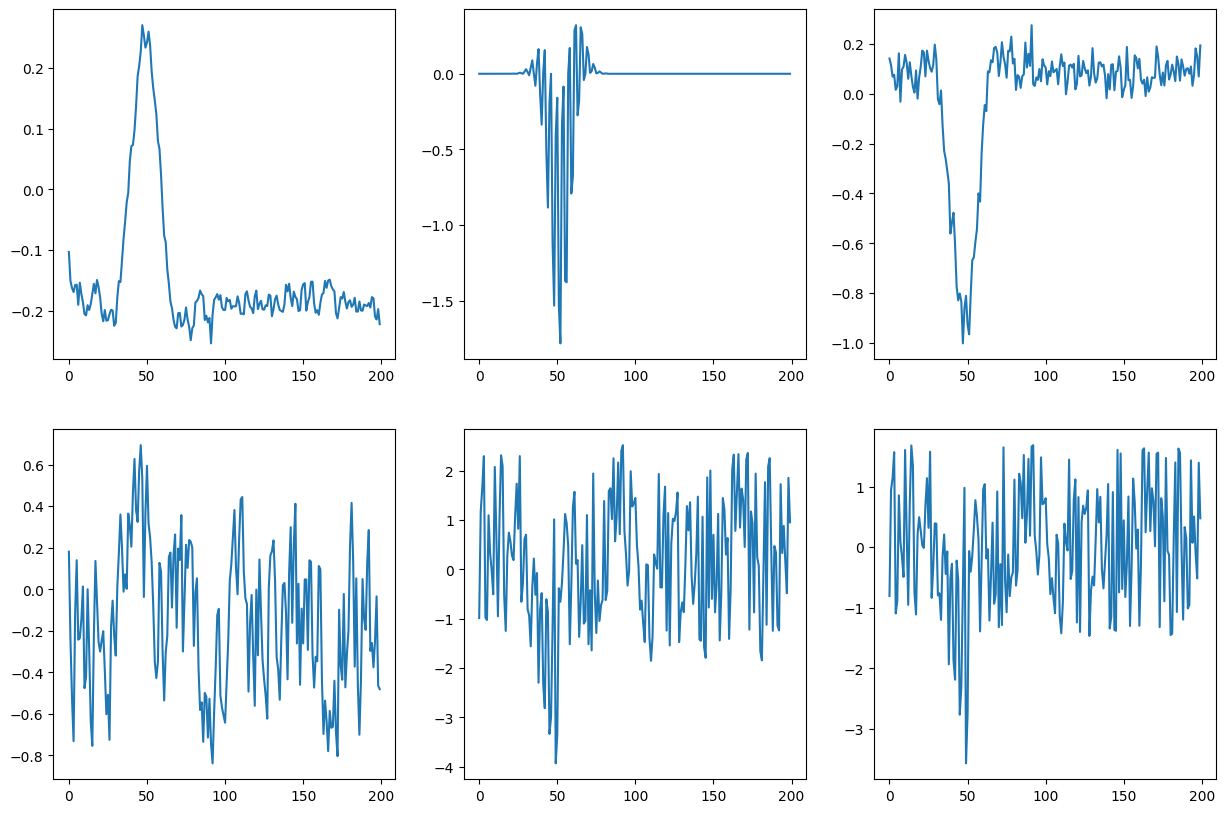

In [86]:
x, y = next(iter(DataLoader(train, len(train))))
labels = np.squeeze(y)
# sig = gen.temp_sel.b.detach().numpy()
# weights = gen.temp_sel.w.detach().numpy()*gen.temp_sel.b.detach().numpy()
x_true = x[np.where(labels == 0)]
sig = gen(x_true).detach().numpy()
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes[0, 0].plot(sig.mean(0).T)
axes[0, 1].plot(s)
r = axes[0, 2].plot(x_true.mean(0).T)
axes[1, 0].plot(sig[0].T)
axes[1, 1].plot((x_true[0] - sig[0]).T)
r = axes[1, 2].plot(x_true[0].T)

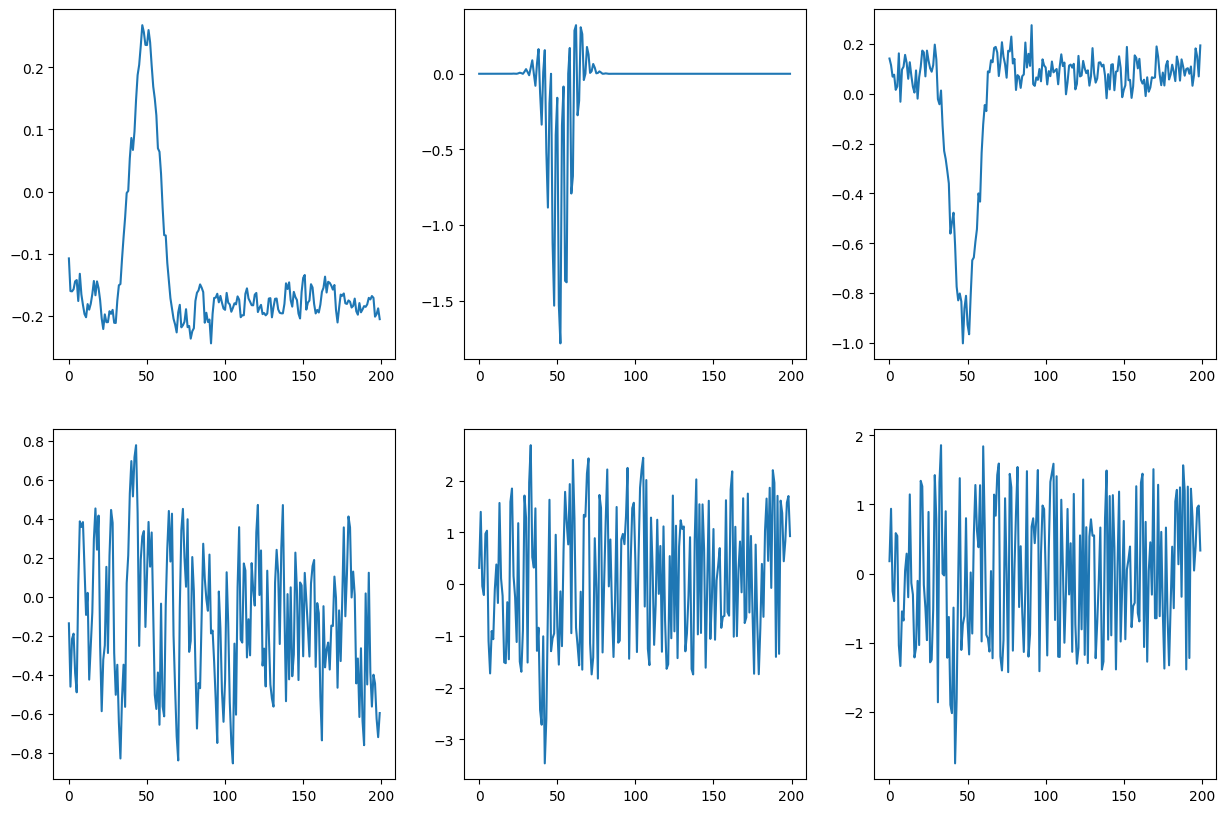

In [83]:
i = np.random.randint(0, len(x_true))

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes[0, 0].plot(sig.mean(0).T)
axes[0, 1].plot(s)
r = axes[0, 2].plot(x_true.mean(0).T)
axes[1, 0].plot(sig[i].T)
axes[1, 1].plot((x_true[i] - sig[i]).T)
r = axes[1, 2].plot(x_true[i].T)

In [58]:
X, Y = next(iter(DataLoader(dataset, len(dataset))))
Xs = gen(X)
X_mod = X - Xs

In [59]:
X_mod = X + Xs

In [60]:
labels = np.squeeze(Y)

In [61]:
x_1 = X[np.where(labels==1)]
x_0 = X[np.where(labels==0)]
x_mod_1 = X_mod[np.where(labels==1)]
x_mod_0 = X_mod[np.where(labels==0)]
xs_1 = Xs[np.where(labels==1)]
xs_0 = Xs[np.where(labels==0)]

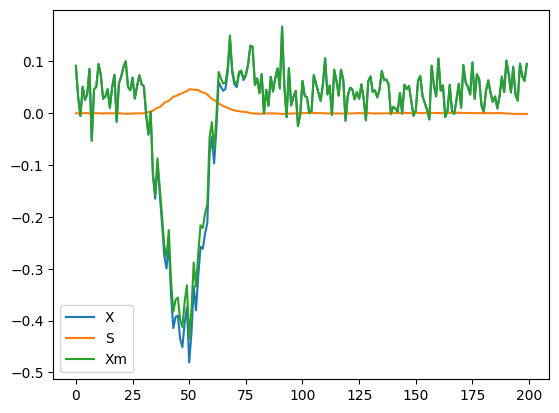

In [62]:
plt.plot(X.detach().mean(0).T)
plt.plot(Xs.detach().mean(0).T)
plt.plot(X_mod.detach().mean(0).T)
plt.legend(['X', 'S', 'Xm'])
plt.show()

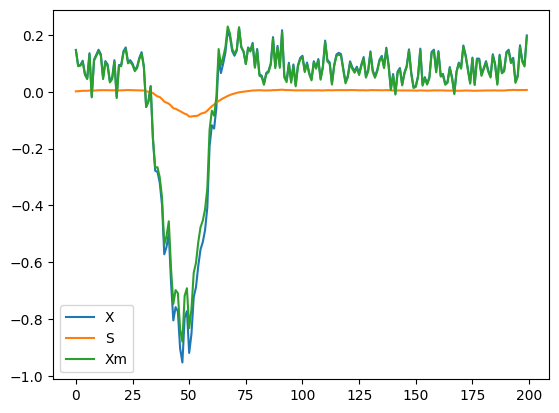

In [63]:
plt.plot(x_0.detach().mean(0).T)
plt.plot(-xs_0.detach().mean(0).T)
plt.plot(x_mod_0.detach().mean(0).T)
plt.legend(['X', 'S', 'Xm'])
plt.show()

In [71]:
x_0.shape

torch.Size([500, 1, 200])

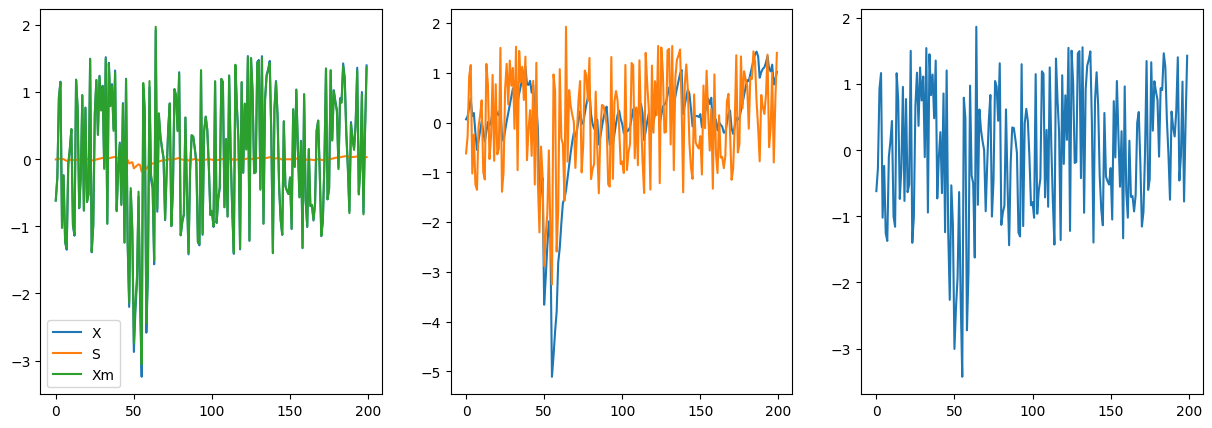

In [68]:
import scipy as sp
i = np.random.randint(len(x_0))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.plot(x_0.detach()[i].T)
ax1.plot(-xs_0.detach()[i].T)
ax1.plot(x_mod_0.detach()[i].T)
ax1.legend(['X', 'S', 'Xm'])
ax2.plot(sp.stats.zscore(-xs_0.detach()[i].T))
ax2.plot(sp.stats.zscore(x_0.detach()[i].T))
ax3.plot((x_0.detach()[i] - xs_0.detach()[i]).T)
plt.show()

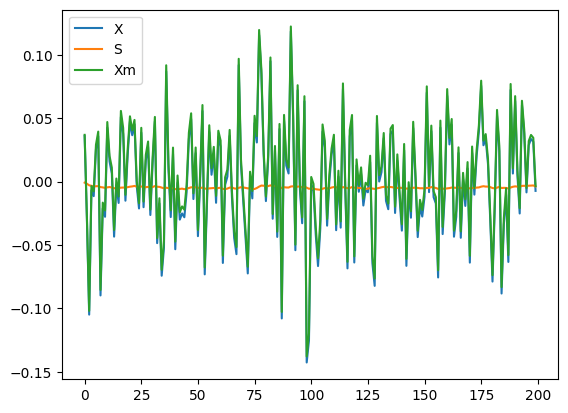

In [65]:
plt.plot(x_1.detach().mean(0).T)
plt.plot(-xs_1.detach().mean(0).T)
plt.plot(x_mod_1.detach().mean(0).T)
plt.legend(['X', 'S', 'Xm'])
plt.show()

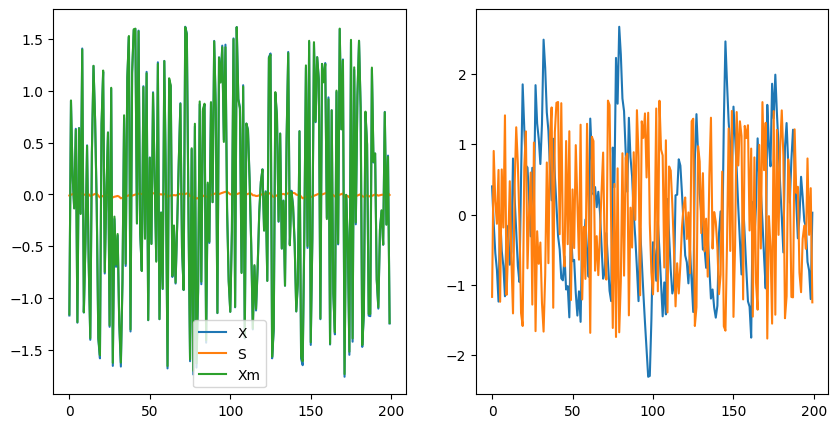

In [66]:
import scipy as sp
i = np.random.randint(len(x_1))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(x_1.detach()[i].T)
ax1.plot(-xs_1.detach()[i].T)
ax1.plot(x_mod_1.detach()[i].T)
ax1.legend(['X', 'S', 'Xm'])
ax2.plot(sp.stats.zscore(xs_1.detach()[i].T))
ax2.plot(sp.stats.zscore(x_1.detach()[i].T))
plt.show()